# Topog form stress using MOM025 DATA

Recent update 22 Aug 2017

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import os
import pickle
from numpy import math

import dask
from dask import delayed
import dask.array as da
import dask.dataframe as dd
from dask.multiprocessing import get
from dask.async import get_sync
from dask.diagnostics import ProgressBar

import pandas as pd
import xarray as xr
from glob import glob
from mpl_toolkits.basemap import Basemap, shiftgrid

#import datashader

# Solve H*dH =0 problem


## 1. new_ddepth    $new\_ddepth_{n+1} = (depth_{n+2}-depth_{n})/2$, then $\int_x depth*ddepth\sim 10^6$
## 2. new_d  set 'NAN' value in depth to be 0, then get new_dH
## $new\_dH_{n+1} = (new\_d_{n+2}-new\_d_{n})/2$, then $\int_x depth*new\_dH\sim 10^{-8}$
## 3. use new_d(nan = 0)*new_dH, $\int_x new\_d*new\_dH\sim10^{-9}$
## 4. define a new_H, $new\_H(n+1) =(new\_d(n+2)+new\_d(n))/2$, then $\int_x new\_H*new\_dH\sim10^{-9}$

In [4]:
## Load data

%time
OceanFile1 = '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup4/output008/ocean/ocean_grid.nc'
dsx1 = xr.open_dataset(OceanFile1, engine='netcdf4')
depth = dsx1.ht   ## H
dxu = dsx1.dxu ## dxu

OceanFile2 =  '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup4/output008/ocean/ocean_month.nc'
dsx2 = xr.open_dataset(OceanFile2, engine='netcdf4')
taux = dxu*dsx2.tau_x.mean('time')  ## tau_x
pbot = dsx2.pbot_t.mean('time')     ## p_bot

OceanFile3 =  '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup4/output008/ocean/ocean.nc'
dsx3 = xr.open_dataset(OceanFile3, engine='netcdf4')
rho = dsx3.rho.mean('time')        ## \rho
dz = dsx3.dzt.mean('time')      ## dzt
g = 9.8196
rho0=1035


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.1 µs


In [5]:
## 1. new_ddepth, new\_ddepth_{n+1} = (depth_{n+2}-depth_{n})/2
new_ddepth = np.zeros(depth.shape)
new_ddepth[:,1:-1] = 0.5*(depth[:,2:].values - depth[:,:-2].values)
new_ddepth[:,0] = 0.5*(depth[:,1].values - depth[:,-1].values)
new_ddepth[:,-1] = 0.5*(depth[:,0].values - depth[:,-2].values)

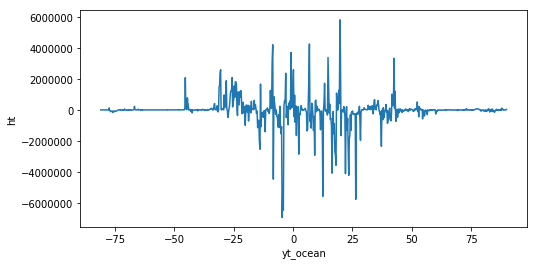

In [11]:
## test depth*new_ddepth circular integral
plt.figure(figsize=(8,4))
tmp1 = depth*new_ddepth
tmp1.sum('xt_ocean').plot()

In [16]:
## 2. set a new depth 'new_d' change NAN to 0
new_d = np.zeros(depth.shape)
new_d = depth.values
new_d[np.isnan(new_d)]=0
print new_d

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [25]:
## new_H using new_d
new_dH = np.zeros(depth.shape)
new_dH[:,1:-1] = 0.5*(new_d[:,2:] - new_d[:,:-2])
new_dH[:,0] = 0.5*(new_d[:,1]- new_d[:,-1])
new_dH[:,-1] = 0.5*(new_d[:,0]- new_d[:,-2])

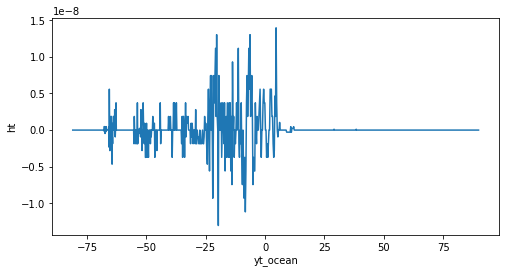

In [19]:
## test depth*new_H circular integral
plt.figure(figsize=(8,4))
tmp2 = depth*new_dH
tmp2.sum('xt_ocean').plot()

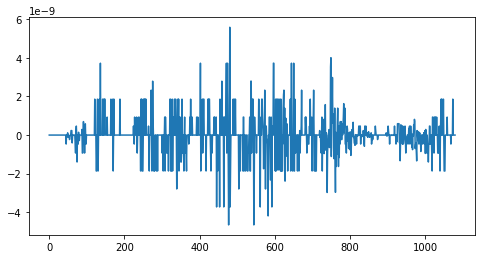

In [22]:
## 3. test new_d*new_dH circular integral
plt.figure(figsize=(8,4))
tmp3 = new_d*new_dH
plt.plot(np.sum(tmp3,axis=1))

In [27]:
## 4. define new_H(n+1) = (new_d(n+2)+new_d(n))/2
new_H = np.zeros(depth.shape)
new_H[:,1:-1] = 0.5*(new_d[:,2:] + new_d[:,:-2])
new_H[:,0] = 0.5*(new_d[:,1]+ new_d[:,-1])
new_H[:,-1] = 0.5*(new_d[:,0]+ new_d[:,-2])

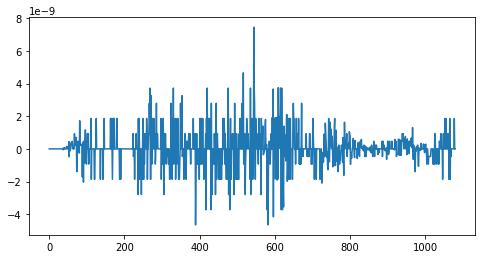

In [28]:
## test new_H*new_dH circular integral
plt.figure(figsize=(8,4))
tmp4 = new_H*new_dH
plt.plot(np.sum(tmp4,axis=1))